In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as Datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
import torchvision.utils as vutils
import os
import random
import numpy as np
import math
from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import trange, tqdm

In [3]:
batchSize = 64
lr = 1e-4

# Number of Training epochs
nepoch = 256

# The size of the Latent Vector
latent_size = 512
root = "../../datasets"

In [4]:
use_cuda = torch.cuda.is_available()
gpu_indx  = 0
device = torch.device(gpu_indx if use_cuda else "cpu")

In [5]:
def vae_loss(recon, x, mu, logvar):
    recon_loss = F.mse_loss(recon, x)
    
    # Here is our KL divergance loss implemented in code
    # We will use the mean across the dimensions instead of the sum (which is common and would require different scaling)
    beta=0.001
    kl_loss = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()
    
    # We'll tune the "strength" of KL divergance loss to get a good result 
    loss = recon_loss + beta * kl_loss
    return loss

In [6]:
# We split up our network into two parts, the Encoder and the Decoder
class DownBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(DownBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, 3, 2, 1)
        self.bn1 = nn.BatchNorm2d(channels_out)
        
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(channels_out)
        
        self.conv3 = nn.Conv2d(channels_in, channels_out, 3, 2, 1)

    def forward(self, x):
        x_skip = self.conv3(x)
        
        x = F.elu(self.bn1(self.conv1(x)))
        x = self.conv2(x) + x_skip
        return F.elu(self.bn2(x))
        
# We split up our network into two parts, the Encoder and the Decoder
class UpBlock(nn.Module):
    def __init__(self, channels_in, channels_out):
        super(UpBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(channels_in)
        self.conv1 = nn.Conv2d(channels_in, channels_in, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(channels_in)
        self.conv2 = nn.Conv2d(channels_in, channels_out, 3, 1, 1)  
        self.conv3 = nn.Conv2d(channels_in, channels_out, 3, 1, 1)
        self.up_nn = nn.Upsample(scale_factor=2, mode="nearest")

    def forward(self, x_in):
        x = F.elu(self.bn2(x_in))
        
        x_skip = self.up_nn(self.conv3(x))
        
        x = self.up_nn(F.elu(self.bn2(self.conv1(x))))
        return self.conv2(x) + x_skip

    
# We split up our network into two parts, the Encoder and the Decoder
class Encoder(nn.Module):
    def __init__(self, channels, ch=32, z=32,latent_dim=1000):
        super(Encoder, self).__init__()
        self.conv_1 = nn.Conv2d(channels, ch, 3, 1, 1)
        self.conv_block1 = DownBlock(ch, ch)
        self.conv_block2 = DownBlock(ch, ch * 2)
        self.conv_block3 = DownBlock(ch * 2, ch * 4)
        self.conv_block4 = DownBlock(ch * 4, ch * 4)
        self.conv_block5 = DownBlock(ch * 4, ch * 4)      
        # Instead of flattening (and then having to unflatten) out our feature map and 
        # putting it through a linear layer we can just use a conv layer
        # where the kernal is the same size as the feature map 
        # (in practice it's the same thing)
        self.conv_mu = nn.Conv2d(4 * ch, z, 4, 1)
        self.conv_logvar = nn.Conv2d(4 * ch, z, 4, 1)
    
        #self.fc_mu = nn.Linear(21632, latent_dim)  
        #self.fc_logvar = nn.Linear(21632, latent_dim)

    # This function will sample from our distribution
    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = F.elu(self.conv_1(x))
        
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)

        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)

        #mu=mu.reshape(mu.shape[0],-1)
        #logvar= logvar.reshape(logvar.shape[0],-1)

        #mu=self.fc_mu(mu)
        #logvar=self.fc_logvar(logvar)
        
        x = self.sample(mu, logvar)
    
        
        return x, mu, logvar
    
    
class Decoder(nn.Module):
    def __init__(self, channels, ch = 32, z = 32,latent_dim=1000):
        super(Decoder, self).__init__()
        self.zT=nn.Linear(latent_dim,21632)
        self.z=z
        self.conv1 = nn.ConvTranspose2d(z, 4 * ch, 4, 1)
        
        self.conv_block1 = UpBlock(4 * ch, 2 * ch)
        self.conv_block2 = UpBlock(2 * ch, ch)
        self.conv_block3 = UpBlock(ch, ch)
        self.conv_block4 = UpBlock(ch, ch)
        self.conv_out = nn.Conv2d(ch, channels, 3, 1, 1)

    def forward(self, x):
        #x=self.zT(x)
        #x=x.reshape(x.shape[0],self.z,13,13)
        x = self.conv1(x)
        
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = F.elu(self.conv_block3(x))

        return torch.tanh(self.conv_out(x))

In [7]:
class VAE(nn.Module):
    def __init__(self, channel_in, ch=16, z=32):
        super(VAE, self).__init__()
        self.encoder = Encoder(channels=channel_in, ch=ch, z=z)
        self.decoder = Decoder(channels=channel_in, ch=ch, z=z)

    def forward(self, x):
        encoding, mu, logvar = self.encoder(x)
        
        # Only sample during training or when we want to generate new images
        # just use mu otherwise
        if self.training:
            x = self.decoder(encoding)
        else:
            x = self.decoder(mu)
            
        return x, mu, logvar

In [8]:
trainer_info = {'epochs': 200,
                'train_size': 3100,
                'train_batch': 32,
                'test_batch': 256,
                'lr0': 1e-3,
                'lr_decay': 0.2}

In [9]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, inp, out):
        self.inp = inp
        self.out = out

    def __len__(self):
        return self.inp.shape[0]

    def __getitem__(self, index):
        return self.inp[index], self.out[index]

In [10]:
imgs2=np.load('cnn_rve_masks_part2_rve.npy')
rng=np.random.default_rng(10)
numbers = rng.choice(4000, size=4000, replace=False)
imgs2= imgs2[numbers].astype(np.float32).copy()
imgs2=imgs2.reshape(4000,imgs2.shape[1],-1,1)
imgs_tensor2 = torch.from_numpy(imgs2).to(device)
imgs_tensor2 = imgs_tensor2.permute(0, 3,1, 2)
num_sample = trainer_info['train_size']
inp_train = imgs_tensor2[0:num_sample, :, :,:]
training_set = MyDataset(inp_train, inp_train)
inp_test = imgs_tensor2[num_sample:num_sample+600, :, :,:]
test_set = MyDataset(inp_test, inp_test)
# create training/test loaders
train_loader = torch.utils.data.DataLoader(dataset=training_set,
                                           batch_size=trainer_info['train_batch'],
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=trainer_info['test_batch'],
                                          shuffle=True)

In [11]:
# Create our network
vae_net = VAE(channel_in=1, z=latent_size).to(device)

# Setup optimizer
optimizer = optim.Adam(vae_net.parameters(), lr=trainer_info['lr0'], betas=(0.5, 0.999))

# Create loss logger
loss_log = []
train_loss = 0

In [12]:
x_,_,_=vae_net(imgs_tensor2[3700:3708])
print(_.shape)

torch.Size([8, 512, 1, 1])


In [13]:
pbar = trange(0, trainer_info['epochs'], leave=False, desc="Epoch")   
vae_net.train()
train_loss = 0
for epoch in pbar:
    pbar.set_postfix_str('Loss: %.4f' % (train_loss/len(train_loader)))
    train_loss = 0
    for i, data in enumerate(tqdm(train_loader, leave=False, desc="Training")):

        image = data[0].to(device)

        # Forward pass the image in the data tuple
        recon_data, mu, logvar = vae_net(image)
        
        # Calculate the loss
        loss = vae_loss(recon_data, image, mu, logvar)
        
        # Log the loss
        loss_log.append(loss.item())
        train_loss += loss.item()

        # Take a training step
        vae_net.zero_grad()
        loss.backward()
        optimizer.step()

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

Training:   0%|          | 0/97 [00:00<?, ?it/s]

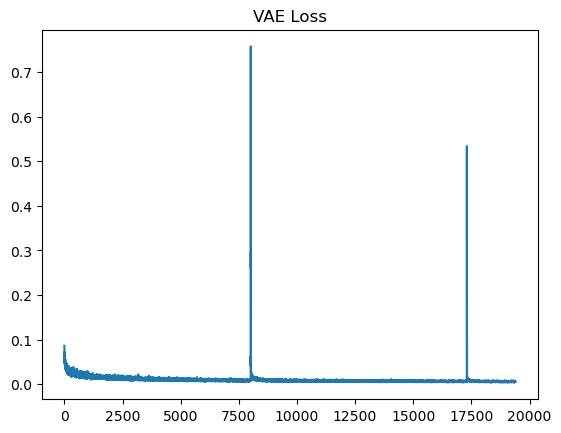

In [14]:
_ = plt.plot(loss_log[10:])
_ = plt.title("VAE Loss")

In [15]:
vae_net.eval()
recon_data, mu, logvar = vae_net(imgs_tensor2[3700:4000].to(device))

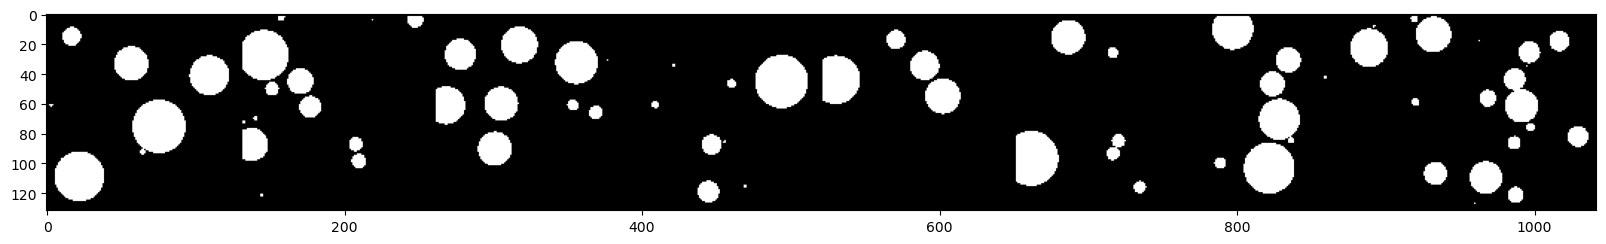

In [16]:
plt.figure(figsize = (20,10))
out = vutils.make_grid(imgs_tensor2[3700:3708], normalize=True).cpu().detach()
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

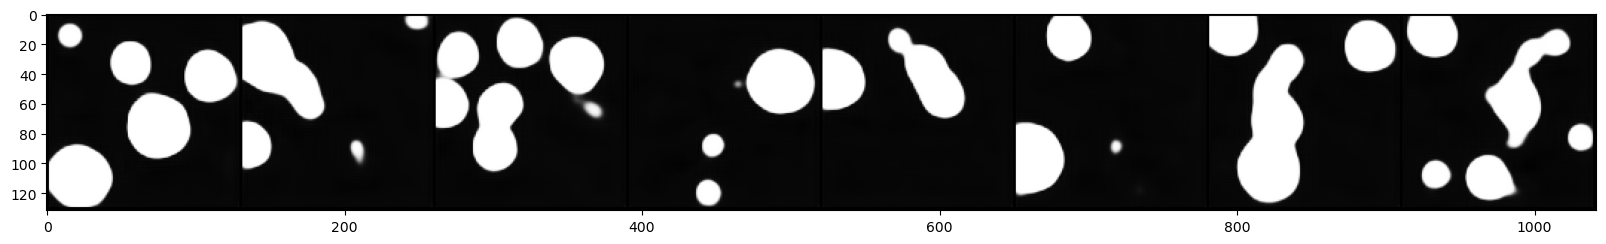

In [17]:
plt.figure(figsize = (20,10))
out = vutils.make_grid(recon_data.detach().cpu()[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

Text(0.5, 1.0, 'True RVE')

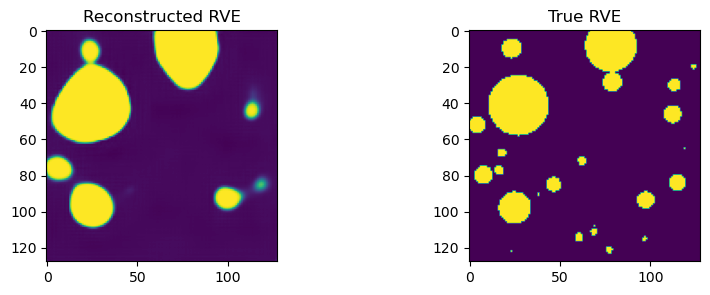

In [19]:
ypred,mu,log_variance = vae_net(imgs_tensor2[3700:4000])
ypred=ypred.to(device)

fig,ax=plt.subplots(1,2,figsize=(10,3))
ax[0].imshow(ypred[234,0,:,:].cpu().detach().numpy())
ax[0].set_title('Reconstructed RVE')
ax[1].imshow(imgs_tensor2[3934,0,:,:].cpu().detach().numpy())
ax[1].set_title('True RVE')
